In [1]:
import os
import pyreadr
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn

# 0. Read data

In [2]:
data_dir = os.path.join("..", "..", "data", "raw")

result_pubmed = pyreadr.read_r(os.path.join(data_dir, "pubmed.rds"))
df_pubmed = list(result_pubmed.values())[0]

result_autoreg = pyreadr.read_r(os.path.join(data_dir, "autoregulatoryDB.rds"))
df_autoreg = list(result_autoreg.values())[0]

print("df_pubmed shape:", df_pubmed.shape)
print("df_autoreg shape:", df_autoreg.shape)

df_pubmed shape: (262819, 5)
df_autoreg shape: (1323976, 13)


In [3]:
df_pubmed.head()

,PMID,Title,Abstract,Journal,Authors
0,15165820,"Comparative genomic analyses of frog virus 3, ...",Frog virus 3 (FV3) is the type species member ...,Virology,"Wendy G H Tan, Todd J Barkman, V Gregory Chinc..."
1,16912294,Genome of invertebrate iridescent virus type 3...,Iridoviruses (IVs) are classified into five ge...,Journal of virology,"Gustavo Delhon, Edan R Tulman, Claudio L Afons..."
2,11448171,Analysis of the first complete DNA sequence of...,"Chilo iridescent virus (CIV), the type species...",Virology,"N J Jakob, K Müller, U Bahr, G Darai"
3,17239238,Comparative genomic analysis of the family Iri...,Members of the family Iridoviridae can cause s...,Virology journal,"Heather E Eaton, Julie Metcalf, Emily Penny, V..."
4,20633916,"Frog virus 3 ORF 53R, a putative myristoylated...",Although previous work identified 12 complemen...,Virology,"Dexter S Whitley, Kwang Yu, Robert C Sample, A..."


In [4]:

missing_abstracts = df_pubmed['Abstract'].isna() | (df_pubmed['Abstract'].str.strip() == '')


df_pubmed[missing_abstracts]


,PMID,Title,Abstract,Journal,Authors
12,8310077,Nucleotide sequence of a stamen- and tapetum-s...,NaN,Plant physiology,"R Chen, A G Smith"
37,17556061,Identification of 2 new sesame seed allergens:...,NaN,The Journal of allergy and clinical immunology,"Kirsten Beyer, Galina Grishina, Ludmilla Bardi..."
70,7972511,Five cDNAs encoding Arabidopsis GF14 proteins.,NaN,Plant physiology,"G Lu, M F Rooney, K Wu, R J Ferl"
71,7870824,Sequences of three Arabidopsis general regulat...,NaN,Plant physiology,"M F Rooney, R J Ferl"
94,8577340,Stage-specific expression of the mRNA encoding...,NaN,Molecular and biochemical parasitology,"D Schechtman, D Ram, R Tarrab-Hazdai, R Arnon,..."
...,...,...,...,...,...
262515,10612253,Physical and linkage mapping of the bovine zin...,NaN,Animal genetics,"I Tammen, W C Warren, H W Raadsma"
262598,21387411,Solution structure of the second PDZ domain of...,NaN,Proteins,"Peng Ji, Guang Yang, Jiahai Zhang, Jiawen Wu, ..."
262667,2541416,Nucleotide sequence of the gene encoding zona ...,NaN,Nucleic acids research,"R A Kinloch, P M Wassarman"
262678,8518738,A trefoil domain in the major rabbit zona pell...,NaN,Protein science : a publication of the Protein...,P Bork


In [5]:
df_autoreg.head()

,AC,OS,RN,RP,RC,RX,RG,RA,RT,RL,Term_in_RP,Term_in_RT,Term_in_RC
0,Q6GZX4,Frog virus 3 (isolate Goorha) (FV-3),[1],NUCLEOTIDE SEQUENCE [LARGE SCALE GENOMIC DNA].,NaN,PubMed=15165820; DOI=10.1016/j.virol.2004.02.019;,NaN,"Tan W.G., Barkman T.J., Gregory Chinchar V., E...","""Comparative genomic analyses of frog virus 3,...",Virology 323:70-84(2004).,,,
1,Q6GZX3,Frog virus 3 (isolate Goorha) (FV-3),[1],NUCLEOTIDE SEQUENCE [LARGE SCALE GENOMIC DNA].,NaN,PubMed=15165820; DOI=10.1016/j.virol.2004.02.019;,NaN,"Tan W.G., Barkman T.J., Gregory Chinchar V., E...","""Comparative genomic analyses of frog virus 3,...",Virology 323:70-84(2004).,,,
2,Q197F8,Invertebrate iridescent virus 3 (IIV-3) (Mosqu...,[1],NUCLEOTIDE SEQUENCE [LARGE SCALE GENOMIC DNA].,NaN,PubMed=16912294; DOI=10.1128/jvi.00464-06;,NaN,"Delhon G., Tulman E.R., Afonso C.L., Lu Z., Be...","""Genome of invertebrate iridescent virus type ...",J. Virol. 80:8439-8449(2006).,,,
3,Q197F7,Invertebrate iridescent virus 3 (IIV-3) (Mosqu...,[1],NUCLEOTIDE SEQUENCE [LARGE SCALE GENOMIC DNA].,NaN,PubMed=16912294; DOI=10.1128/jvi.00464-06;,NaN,"Delhon G., Tulman E.R., Afonso C.L., Lu Z., Be...","""Genome of invertebrate iridescent virus type ...",J. Virol. 80:8439-8449(2006).,,,
4,Q6GZX2,Frog virus 3 (isolate Goorha) (FV-3),[1],NUCLEOTIDE SEQUENCE [LARGE SCALE GENOMIC DNA].,NaN,PubMed=15165820; DOI=10.1016/j.virol.2004.02.019;,NaN,"Tan W.G., Barkman T.J., Gregory Chinchar V., E...","""Comparative genomic analyses of frog virus 3,...",Virology 323:70-84(2004).,,,


# 1. Data Cleaning

Join these two dataframes

In [6]:
# extract PMID from RX column and join with pubmed data
df_autoreg['PMID'] = df_autoreg['RX'].str.extract(r'PubMed=(\d+)')

df_autoreg['PMID'] = df_autoreg['PMID'].astype(str)
df_pubmed['PMID'] = df_pubmed['PMID'].astype(str)

df_merged = pd.merge(df_autoreg, df_pubmed, on='PMID', how='left')

print(df_merged.shape)
df_merged.head()

(1323976, 18)


,AC,OS,RN,RP,RC,RX,RG,RA,RT,RL,Term_in_RP,Term_in_RT,Term_in_RC,PMID,Title,Abstract,Journal,Authors
0,Q6GZX4,Frog virus 3 (isolate Goorha) (FV-3),[1],NUCLEOTIDE SEQUENCE [LARGE SCALE GENOMIC DNA].,NaN,PubMed=15165820; DOI=10.1016/j.virol.2004.02.019;,NaN,"Tan W.G., Barkman T.J., Gregory Chinchar V., E...","""Comparative genomic analyses of frog virus 3,...",Virology 323:70-84(2004).,,,,15165820,"Comparative genomic analyses of frog virus 3, ...",Frog virus 3 (FV3) is the type species member ...,Virology,"Wendy G H Tan, Todd J Barkman, V Gregory Chinc..."
1,Q6GZX3,Frog virus 3 (isolate Goorha) (FV-3),[1],NUCLEOTIDE SEQUENCE [LARGE SCALE GENOMIC DNA].,NaN,PubMed=15165820; DOI=10.1016/j.virol.2004.02.019;,NaN,"Tan W.G., Barkman T.J., Gregory Chinchar V., E...","""Comparative genomic analyses of frog virus 3,...",Virology 323:70-84(2004).,,,,15165820,"Comparative genomic analyses of frog virus 3, ...",Frog virus 3 (FV3) is the type species member ...,Virology,"Wendy G H Tan, Todd J Barkman, V Gregory Chinc..."
2,Q197F8,Invertebrate iridescent virus 3 (IIV-3) (Mosqu...,[1],NUCLEOTIDE SEQUENCE [LARGE SCALE GENOMIC DNA].,NaN,PubMed=16912294; DOI=10.1128/jvi.00464-06;,NaN,"Delhon G., Tulman E.R., Afonso C.L., Lu Z., Be...","""Genome of invertebrate iridescent virus type ...",J. Virol. 80:8439-8449(2006).,,,,16912294,Genome of invertebrate iridescent virus type 3...,Iridoviruses (IVs) are classified into five ge...,Journal of virology,"Gustavo Delhon, Edan R Tulman, Claudio L Afons..."
3,Q197F7,Invertebrate iridescent virus 3 (IIV-3) (Mosqu...,[1],NUCLEOTIDE SEQUENCE [LARGE SCALE GENOMIC DNA].,NaN,PubMed=16912294; DOI=10.1128/jvi.00464-06;,NaN,"Delhon G., Tulman E.R., Afonso C.L., Lu Z., Be...","""Genome of invertebrate iridescent virus type ...",J. Virol. 80:8439-8449(2006).,,,,16912294,Genome of invertebrate iridescent virus type 3...,Iridoviruses (IVs) are classified into five ge...,Journal of virology,"Gustavo Delhon, Edan R Tulman, Claudio L Afons..."
4,Q6GZX2,Frog virus 3 (isolate Goorha) (FV-3),[1],NUCLEOTIDE SEQUENCE [LARGE SCALE GENOMIC DNA].,NaN,PubMed=15165820; DOI=10.1016/j.virol.2004.02.019;,NaN,"Tan W.G., Barkman T.J., Gregory Chinchar V., E...","""Comparative genomic analyses of frog virus 3,...",Virology 323:70-84(2004).,,,,15165820,"Comparative genomic analyses of frog virus 3, ...",Frog virus 3 (FV3) is the type species member ...,Virology,"Wendy G H Tan, Todd J Barkman, V Gregory Chinc..."


Since we are not going to use all these columns, we droped unwanted ones

In [7]:
columns_to_keep = ['AC', 'OS', 'PMID', 'Title', 'Abstract', 'Term_in_RP', 'Term_in_RT', 'Term_in_RC']

df_selected = df_merged[columns_to_keep].copy()

These three 'Term_xxx' columns can be combined into one column

In [8]:
def merge_terms(row):
    cols = ['Term_in_RP', 'Term_in_RT', 'Term_in_RC']
    terms = []

    for col in cols:
        val = row[col]
        if pd.notna(val):
            split_terms = [t.strip() for t in str(val).split(',') if t.strip()]
            terms.extend(split_terms)

    return ', '.join(sorted(set(terms))) if terms else ''


df_selected['Terms'] = df_selected.apply(merge_terms, axis=1)

print(df_selected.shape)

(1323976, 9)


After combining all these three 'Terms_' column, we got our final 'Terms' column so that can be used later when we build model. And we can now drop these three 'Terms_' columns and only keep the final one

In [9]:
# number of rows that has multiple 'Terms'
df_selected[df_selected['Terms'].str.contains(',')]['Terms'].count()

np.int64(37)

In [10]:
df_cleaned = df_selected.drop(columns=['Term_in_RP', 'Term_in_RT', 'Term_in_RC'])
print(df_cleaned.shape)
df_cleaned[df_cleaned['Terms'] != ''].head()

(1323976, 6)


,AC,OS,PMID,Title,Abstract,Terms
1085,P63104,Homo sapiens (Human),29357390,Herpesvirus deconjugases inhibit the IFN respo...,The N-terminal domains of the herpesvirus larg...,autoubiquitination
5416,Q64264,Mus musculus (Mouse),18599790,Sporadic autonomic dysregulation and death ass...,Sudden infant death syndrome is the leading ca...,autoinhibition
5891,Q9Y6E2,Homo sapiens (Human),29470543,Translational autoregulation of BZW1 and BZW2 ...,The efficiency of start codon selection during...,autoregulation
5926,Q7L1Q6,Homo sapiens (Human),29470543,Translational autoregulation of BZW1 and BZW2 ...,The efficiency of start codon selection during...,autoregulation
9655,Q13131,Homo sapiens (Human),17088252,Conserved alpha-helix acts as autoinhibitory s...,AMP-activated protein kinase (AMPK) acts as an...,autoinhibitory


In [11]:
df_cleaned

,AC,OS,PMID,Title,Abstract,Terms
0,Q6GZX4,Frog virus 3 (isolate Goorha) (FV-3),15165820,"Comparative genomic analyses of frog virus 3, ...",Frog virus 3 (FV3) is the type species member ...,
1,Q6GZX3,Frog virus 3 (isolate Goorha) (FV-3),15165820,"Comparative genomic analyses of frog virus 3, ...",Frog virus 3 (FV3) is the type species member ...,
2,Q197F8,Invertebrate iridescent virus 3 (IIV-3) (Mosqu...,16912294,Genome of invertebrate iridescent virus type 3...,Iridoviruses (IVs) are classified into five ge...,
3,Q197F7,Invertebrate iridescent virus 3 (IIV-3) (Mosqu...,16912294,Genome of invertebrate iridescent virus type 3...,Iridoviruses (IVs) are classified into five ge...,
4,Q6GZX2,Frog virus 3 (isolate Goorha) (FV-3),15165820,"Comparative genomic analyses of frog virus 3, ...",Frog virus 3 (FV3) is the type species member ...,
...,...,...,...,...,...,...
1323971,Q88470,Tacaribe virus (strain Franze-Fernandez) (TCRV),12970423,Tacaribe virus Z protein interacts with the L ...,Tacaribe virus (TV) is the prototype of the Ne...,
1323972,A9JR22,Tamiami mammarenavirus (isolate Rat/United Sta...,17624390,Principal host relationships and evolutionary ...,A previous study suggested that the genomes of...,
1323973,A9JR22,Tamiami mammarenavirus (isolate Rat/United Sta...,nan,NaN,NaN,
1323974,A9JR22,Tamiami mammarenavirus (isolate Rat/United Sta...,18602020,Phylogeny of the genus Arenavirus.,The family Arenaviridae consists of a unique g...,


# 2. EDA

**A. Proportion of Entries with Non-Empty Terms**

In [12]:
total_rows = len(df_selected)

def count_non_empty(col):
    return df_selected[col].apply(lambda x: pd.notna(x) and str(x).strip() != '').sum()

non_empty_rp = count_non_empty('Term_in_RP')
non_empty_rt = count_non_empty('Term_in_RT')
non_empty_rc = count_non_empty('Term_in_RC')
non_empty_terms = df_selected['Terms'].str.strip().ne('').sum()

term_column_check = pd.DataFrame({
    'Column': ['Term_in_RP', 'Term_in_RT', 'Term_in_RC', 'Merged Terms'],
    'Non-Empty Count': [non_empty_rp, non_empty_rt, non_empty_rc, non_empty_terms],
    'Proportion': [f"{non_empty_rp/total_rows:.2%}",
                   f"{non_empty_rt/total_rows:.2%}",
                   f"{non_empty_rc/total_rows:.2%}",
                   f"{non_empty_terms/total_rows:.2%}"]
})

term_column_check

,Column,Non-Empty Count,Proportion
0,Term_in_RP,1012,0.08%
1,Term_in_RT,901,0.07%
2,Term_in_RC,0,0.00%
3,Merged Terms,1823,0.14%


We examined how many rows in the dataset had non-empty values in the Terms column, compared to the total number of rows. Only 1,823 rows, which is about 0.14% of the dataset, contained valid terms. 

This shows that term annotations are available for only a very small portion of the data, while the vast majority remains unlabeled.

**B. Entries with Multiple Terms**

In [13]:
multi_term_rows = df_cleaned[df_cleaned['Terms'].str.count(',') >= 1]

multi_term_count = len(multi_term_rows)
labeled_count = df_cleaned['Terms'].str.strip().ne('').sum()

multi_term_ratio = multi_term_count / labeled_count

df_multi_term_stats = pd.DataFrame({
    '': ['Labeled with multiple terms', 'Labeled with a single term'],
    'Count': [multi_term_count, labeled_count - multi_term_count],
    'Proportion': [f"{multi_term_ratio:.2%}", f"{1 - multi_term_ratio:.2%}"]
})

df_multi_term_stats

,,Count,Proportion
0,Labeled with multiple terms,37,2.03%
1,Labeled with a single term,1786,97.97%


We checked how many labeled entries had more than one term assigned. Out of all labeled rows, 2.03% contained multiple terms. This shows that most entries were labeled with a single term, though a small portion involves multiple regulatory types

**C. Label Frequency**

In [14]:
all_terms = [
    term.strip()
    for terms in df_cleaned['Terms']
    if terms.strip() != ''
    for term in terms.split(',')
    if term.strip()
]

term_counts = Counter(all_terms)
df_term_counts = pd.DataFrame(term_counts.items(), columns=['Term', 'Count']).sort_values(by='Count', ascending=False)

total_terms = sum(term_counts.values())
df_term_counts['Percent'] = df_term_counts['Count'] / total_terms * 100

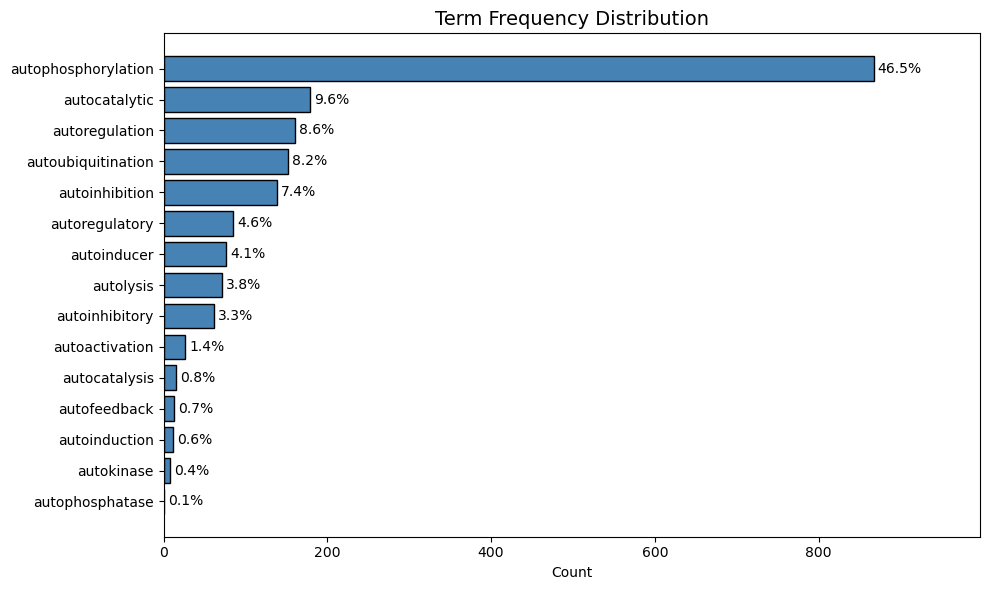

In [15]:
plt.figure(figsize=(10, 6))
bars = plt.barh(df_term_counts['Term'], df_term_counts['Count'], color='steelblue', edgecolor='black')
plt.gca().invert_yaxis()
plt.xlabel("Count")
plt.title("Term Frequency Distribution", fontsize=14)
plt.xlim(0, df_term_counts['Count'].max() * 1.15)


for bar, percent in zip(bars, df_term_counts['Percent']):
    plt.text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2,
             f"{percent:.1f}%", va='center', fontsize=10)

plt.tight_layout()
plt.show()

We counted the most common terms in the labeled subset of the data. The term list was extracted by splitting and cleaning the entries in the Terms column. A small number of keywords appeared multiple times. 

This shows that, even within the labeled rows, the distribution is imbalanced, with a few terms occurring much more frequently than others. We can see that nearly half of the labeled entries are assigned the term autophosphorylation, while most other terms occur far less often.

**D. Distribution of Top Terms Across Organisms**

In [16]:
df_exploded = df_cleaned[df_cleaned['Terms'].str.strip() != ''].copy()
df_exploded['Terms'] = df_exploded['Terms'].str.split(',')
df_exploded = df_exploded.explode('Terms')
df_exploded['Terms'] = df_exploded['Terms'].str.strip()

top5_terms = df_term_counts['Term'].head(5).tolist()
df_term_os = df_exploded[df_exploded['Terms'].isin(top5_terms)]
df_grouped = df_term_os.groupby(['Terms', 'OS']).size().reset_index(name='Count')

top_organisms_per_term = (
    df_grouped
    .sort_values(['Terms', 'Count'], ascending=[True, False])
    .groupby('Terms')
    .head(3)
    .reset_index(drop=True)
)

top_organisms_per_term

,Terms,OS,Count
0,autocatalytic,Homo sapiens (Human),50
1,autocatalytic,Mus musculus (Mouse),20
2,autocatalytic,Arabidopsis thaliana (Mouse-ear cress),11
3,autoinhibition,Homo sapiens (Human),86
4,autoinhibition,Mus musculus (Mouse),21
5,autoinhibition,Rattus norvegicus (Rat),8
6,autophosphorylation,Homo sapiens (Human),338
7,autophosphorylation,Arabidopsis thaliana (Mouse-ear cress),120
8,autophosphorylation,Mus musculus (Mouse),97
9,autoregulation,Homo sapiens (Human),26


We explored how the top five terms are distributed across organisms. This table shows the top five most frequent terms, and the three organisms where each term appears most often. It highlights the dominant species associated with each term, helping us see which organisms are most commonly linked to certain regulatory mechanisms. 

Autophosphorylation, for instance, appears most frequently in Human, Mouse-ear cress, and Mouse.

**E. Terms Appears in Features**

In [17]:
def term_in_text(row, text_field):
    if not row['Terms'].strip():
        return False
    terms = [t.strip().lower() for t in row['Terms'].split(',')]
    text = str(row[text_field]).lower()
    return any(term in text for term in terms)

df_cleaned['Term_in_Title'] = df_cleaned.apply(lambda row: term_in_text(row, 'Title'), axis=1)
df_cleaned['Term_in_Abstract'] = df_cleaned.apply(lambda row: term_in_text(row, 'Abstract'), axis=1)

in_title = df_cleaned['Term_in_Title'].sum()
in_abstract = df_cleaned['Term_in_Abstract'].sum()
labeled_total = df_cleaned['Terms'].str.strip().ne('').sum()

df_term_in_text = pd.DataFrame({
    '': ['In Title', 'In Abstract'],
    'Matched Count': [in_title, in_abstract],
    'Proportion': [f"{in_title / labeled_total:.2%}", f"{in_abstract / labeled_total:.2%}"]
})

df_term_in_text

,,Matched Count,Proportion
0,In Title,881,48.33%
1,In Abstract,865,47.45%


We checked whether the assigned terms appear in either the title or abstract. We can see taht nearly half of the terms are directly reflected in the text, especially in titles

**F. Length Distribution of Abstract**

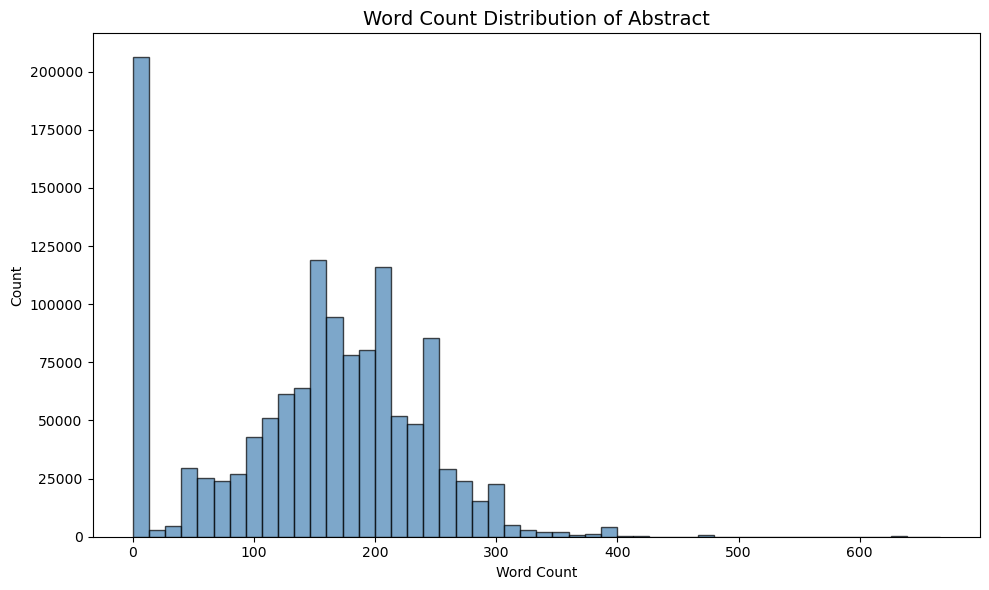

In [18]:
abstract_words = df_cleaned['Abstract'].fillna('').apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
plt.hist(abstract_words, bins=50, alpha=0.7,
         label='Abstract', color='steelblue', edgecolor='black')
plt.xlabel("Word Count")
plt.ylabel("Count")
plt.title("Word Count Distribution of Abstract", fontsize=14)
plt.tight_layout()
plt.show()

We analyzed the word count distribution of abstracts. Most abstracts ranged from 100 to 200 words, with a median of 161 words. The longest abstracts reached up to 666 words, though these were rare. Since we might use BERT model later, based on this distribution, a BERT max_length of 256 or 384 tokens should be sufficient to cover most abstracts without heavy truncation

In [19]:
# Keep only rows with at least one label
df_labeled = df_cleaned[df_cleaned['Terms'].apply(lambda x: len(x) > 0)]
print(f"Labeled rows: {len(df_labeled)} out of {len(df_cleaned)}")
print(f"= {100 * len(df_labeled) / len(df_cleaned):.2f}% of total")



Labeled rows: 1823 out of 1323976
= 0.14% of total


In [20]:
df_labeled.shape[0]


1823

#### The class distribution is very imbalanced, autophosphorylation: 850 samples (~46.6%). Many classes have < 5 samples, some only 1.

## Preprocessing Text for Modeling

In [21]:
import re
import pandas as pd

# Step 1: Drop rows with missing or empty Title or Abstract
df_labeled = df_labeled.dropna(subset=['Title', 'Abstract'])
df_labeled = df_labeled[
    df_labeled['Title'].apply(lambda x: isinstance(x, str) and len(x.strip()) > 0) &
    df_labeled['Abstract'].apply(lambda x: isinstance(x, str) and len(x.strip()) > 0)
].copy()

# Step 2: Preprocessing function
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = text.strip()
    text = re.sub(r'\s+', ' ', text)             # remove extra whitespace/newlines
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)   # remove non-printable characters
    return text

# Step 3: Apply preprocessing to Title and Abstract
df_labeled['Title_clean'] = df_labeled['Title'].apply(preprocess_text)
df_labeled['Abstract_clean'] = df_labeled['Abstract'].apply(preprocess_text)

# Step 4: Concatenate cleaned Title and Abstract
df_labeled['Text_combined'] = df_labeled['Title_clean'] + " " + df_labeled['Abstract_clean']

# Step 5: Sanity check
print("Shape after cleaning:", df_labeled.shape)
print(df_labeled[['Title_clean', 'Abstract_clean', 'Text_combined']].head(3))


Shape after cleaning: (1781, 11)
                                            Title_clean  \
1085  Herpesvirus deconjugases inhibit the IFN respo...   
5416  Sporadic autonomic dysregulation and death ass...   
5891  Translational autoregulation of BZW1 and BZW2 ...   

                                         Abstract_clean  \
1085  The N-terminal domains of the herpesvirus larg...   
5416  Sudden infant death syndrome is the leading ca...   
5891  The efficiency of start codon selection during...   

                                          Text_combined  
1085  Herpesvirus deconjugases inhibit the IFN respo...  
5416  Sporadic autonomic dysregulation and death ass...  
5891  Translational autoregulation of BZW1 and BZW2 ...  


In [22]:
# Check IF Abstract_clean is preprocessed and clean to used
df_labeled['Abstract_clean'].apply(lambda x: isinstance(x, str) and len(x.strip()) > 0).all()


np.True_

In [23]:
# Check IF Title is preprocessed and clean to used
df_labeled['Title'].apply(lambda x: isinstance(x, str) and len(x.strip()) > 0).all()

np.True_

In [24]:
# Check IF Terms is preprocessed and clean to used
df_labeled['Terms'].apply(lambda x: isinstance(x, str) and len(x.strip()) > 0).all()


np.True_

In [25]:
df_labeled.shape[0]

1781

### Binarize the Multi-Label Terms

In [26]:
from sklearn.preprocessing import MultiLabelBinarizer

# Split terms into lists
df_labeled['Term_list'] = df_labeled['Terms'].apply(
    lambda x: [t.strip() for t in x.split(',')] if isinstance(x, str) else []
)

# Initialize and fit binarizer
mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(df_labeled['Term_list'])

# Save label classes for later use
label_classes = mlb.classes_


In [27]:
label_classes 

array(['autoactivation', 'autocatalysis', 'autocatalytic', 'autofeedback',
       'autoinducer', 'autoinduction', 'autoinhibition', 'autoinhibitory',
       'autokinase', 'autolysis', 'autophosphatase',
       'autophosphorylation', 'autoregulation', 'autoregulatory',
       'autoubiquitination'], dtype=object)

In [28]:
print(Y.shape)  # (1781, num_classes)



(1781, 15)


In [29]:
label_counts = pd.Series(Y.sum(axis=0), index=label_classes).sort_values(ascending=False)

print(label_counts)

autophosphorylation    849
autocatalytic          177
autoregulation         154
autoubiquitination     146
autoinhibition         137
autoregulatory          85
autoinducer             73
autolysis               70
autoinhibitory          60
autoactivation          22
autocatalysis           15
autofeedback            13
autoinduction           11
autokinase               8
autophosphatase          1
dtype: int64


In [30]:
# If a term appears only once it’s unlikely the model will learn meaningful patterns. It may bias the loss function if class weights are applied

term_to_drop = "autophosphatase"  

# Find index 
drop_idx = list(label_classes).index(term_to_drop)

# Drop the corresponding column from Y
Y = np.delete(Y, drop_idx, axis=1)

# Remove the term from label_classes
label_classes = [label for i, label in enumerate(label_classes) if i != drop_idx]

print(Y.shape)  # (1781, num_classes)


(1781, 14)


In [31]:
# drop meaningless columns
df_labeled.drop(columns=['OS', 'Term_in_Title', 'Terms', 'Term_in_Abstract','Title_clean','Abstract_clean'], inplace=True)


In [32]:
# Shuffle the dataset 
from sklearn.utils import shuffle

df_labeled_shuffled, Y_shuffled = shuffle(df_labeled, Y, random_state=42)

# Assign them back if needed
df_labeled = df_labeled_shuffled.reset_index(drop=True)
Y = Y_shuffled

In [33]:
df_labeled 


,AC,PMID,Title,Abstract,Text_combined,Term_list
0,Q6TFL4,27798626,Stabilizing mutations of KLHL24 ubiquitin liga...,Skin integrity is essential for protection fro...,Stabilizing mutations of KLHL24 ubiquitin liga...,[autoubiquitination]
1,Q92673,20015111,GGA autoinhibition revisited.,The cytosolic adaptors GGA1-3 mediate sorting ...,GGA autoinhibition revisited. The cytosolic ad...,[autoinhibition]
2,P0A964,2068106,Bacterial chemotaxis signaling complexes: form...,We have demonstrated that a complex of the pro...,Bacterial chemotaxis signaling complexes: form...,[autophosphorylation]
3,Q13557,14722083,Comparative analyses of the three-dimensional ...,Ca(2+)-calmodulin-dependent protein kinase II ...,Comparative analyses of the three-dimensional ...,[autophosphorylation]
4,P74646,23449916,Biochemical analysis of three putative KaiC cl...,Cyanobacteria have been shown to have a circad...,Biochemical analysis of three putative KaiC cl...,[autophosphorylation]
...,...,...,...,...,...,...
1776,Q13177,9786869,Cleavage and activation of p21-activated prote...,"p21-activated protein kinase gamma-PAK (Pak2, ...",Cleavage and activation of p21-activated prote...,[autophosphorylation]
1777,P09232,1744078,Activation of the proteinase B precursor of th...,Proteinase B (PrB) is a subtilisin-like serine...,Activation of the proteinase B precursor of th...,[autocatalysis]
1778,A0A1Q3EPD6,31117659,Distinct Autocatalytic α- N-Methylating Precur...,Backbone N-methylations impart several favorab...,Distinct Autocatalytic - N-Methylating Precur...,[autocatalytic]
1779,Q8BKJ9,28923965,Sirt7 promotes adipogenesis in the mouse by in...,Sirtuins (Sirt1-Sirt7) are NAD+-dependent prot...,Sirt7 promotes adipogenesis in the mouse by in...,[autocatalytic]


In [34]:
df_labeled.to_csv("preprocessed_data.csv", index=False)
